# Modeling and Simuation Final Project v3
## DATA604 - Summer 2020
### Completed by: Philip Tanofsky
### Date: June 28, 2020

#### v3: Contains all of v2 and attempt to track stats per game

In [75]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import *

import numpy as np

import math

import time

In [2]:
# Read in statistics for all 30 NBA teams
filename = 'Teams_Stats_Sim_v3.csv'
all_teams = read_csv(filename, header=0, decimal='M')

# Rename the columns
all_teams.columns = ['team', 'turnover_pct_per_play', 'fga_pct_per_play', 'off_reb_per_play', 'two_pt_fg_attempts_pct', 
                  'two_pt_fg_shooting_pct', 'three_pt_fg_shooting_pct', 'ft_shooting_pct', 'shooting_foul_drawn_pct', 
                  'pace', 'off_rating', 'def_rating']


# Cast the appropriate columns to numeric instead of string
cols = ['turnover_pct_per_play', 'fga_pct_per_play', 'off_reb_per_play', 'two_pt_fg_attempts_pct', 
                  'two_pt_fg_shooting_pct', 'three_pt_fg_shooting_pct', 'ft_shooting_pct', 'shooting_foul_drawn_pct', 
                  'pace', 'off_rating', 'def_rating']   

all_teams[cols] = all_teams[cols].apply(pd.to_numeric, errors='coerce')

# Output the complete input file just for visual validation
all_teams

,team,turnover_pct_per_play,fga_pct_per_play,off_reb_per_play,two_pt_fg_attempts_pct,two_pt_fg_shooting_pct,three_pt_fg_shooting_pct,ft_shooting_pct,shooting_foul_drawn_pct,pace,off_rating,def_rating
0,ATL,0.137,0.889,0.084,0.602,0.525,0.333,0.790,0.082,103.28,107.0,114.4
1,BOS,0.119,0.886,0.093,0.618,0.519,0.363,0.801,0.079,99.78,112.3,106.2
2,BKN,0.132,0.884,0.092,0.580,0.519,0.340,0.744,0.077,101.51,107.8,108.3
3,CHA,0.132,0.892,0.099,0.601,0.489,0.352,0.748,0.091,96.24,105.9,112.8
4,CHI,0.135,0.897,0.092,0.604,0.511,0.348,0.755,0.079,100.46,105.8,108.9
5,CLE,0.144,0.898,0.095,0.638,0.519,0.351,0.758,0.085,99.17,106.9,114.8
6,DAL,0.112,0.886,0.093,0.539,0.542,0.369,0.773,0.081,99.78,115.8,110.0
7,DEN,0.121,0.896,0.095,0.658,0.529,0.358,0.775,0.086,97.66,112.0,108.9
8,DET,0.136,0.887,0.087,0.619,0.515,0.367,0.743,0.079,97.86,108.8,112.3
9,GST,0.130,0.882,0.087,0.645,0.495,0.334,0.803,0.072,101.04,104.4,113.0


## Thoughts

### Functions:

- simulate_possession: DONE

- simulate_FT_attempt: DONE

- simulate_FT_attempts: DONE

- simulate_2P_FG_attempt: DONE

- simulate_3P_FG_attempt: DONE

- simulate_missed_shot

- did_turnover_occur: DONE

- did_field_goal_attempt_occur: DONE

- is_2P_FGA: DONE

- is_2P_FGA_made: DONE

- is_3P_FGA_made: DONE

- is_FTA_made: DONE

- did_shooting_foul_occur: DONE

- did_offensive_rebound_occur: DONE

- define team

- is game tied

- simulate overtime

- map team stats to system: DONE

### Utility functions

- def convert_pct_to_int(pct): DONE

### Thoughts

- team is a system

- game is a state

- graph of point outcomes for a team, look at distribution

- graph of point differences between two teams

- give two teams as input to run game simulation

- give two teams as input to run 7-game series simulation

- Doesn't take into account nuances of blow-game in which star players sit out most of 4th quarter, pace of game purposely slowed down by winning team

In [3]:
def map_team_stats_to_system(team):
    """
    Given the team 3-character identifier, create a system object based on the input file of team statistics
    """
    team_stats = all_teams[all_teams['team']== team]
    
    team_sys = System(turnover_pct_per_play=team_stats.iloc[0]['turnover_pct_per_play'],
                fga_pct_per_play           =team_stats.iloc[0]['fga_pct_per_play'],
                off_reb_per_play           =team_stats.iloc[0]['off_reb_per_play'],
                two_pt_fg_attempts_pct     =team_stats.iloc[0]['two_pt_fg_attempts_pct'],
                two_pt_fg_shooting_pct     =team_stats.iloc[0]['two_pt_fg_shooting_pct'],
                three_pt_fg_shooting_pct   =team_stats.iloc[0]['three_pt_fg_shooting_pct'],
                ft_shooting_pct            =team_stats.iloc[0]['ft_shooting_pct'],
                shooting_foul_drawn_pct    =team_stats.iloc[0]['shooting_foul_drawn_pct'],
                pace                       =team_stats.iloc[0]['pace'],
                off_rating                 =team_stats.iloc[0]['off_rating'],
                def_rating                 =team_stats.iloc[0]['def_rating'])
    
    return team_sys

In [4]:
# Test map_team_stats_to_system
atl = map_team_stats_to_system('ATL')

,values
turnover_pct_per_play,0.137
fga_pct_per_play,0.889
off_reb_per_play,0.084
two_pt_fg_attempts_pct,0.602
two_pt_fg_shooting_pct,0.525
three_pt_fg_shooting_pct,0.333
ft_shooting_pct,0.790
shooting_foul_drawn_pct,0.082
pace,103.280
off_rating,107.000


In [5]:
def initialize_game_stats_state():
    """
    Initialize the game statistics to zero and return State object
    """
    game_stats_state = State(turnovers=0,
                             two_point_field_goal_attempts=0,
                             two_point_field_goal_makes=0,
                             three_point_field_goal_attempts=0,
                             three_point_field_goal_makes=0,
                             free_throw_attempts=0,
                             free_throw_makes=0,
                             shooting_fouls_drawn=0,
                             offensive_rebounds=0)
    
    return game_stats_state

In [6]:
# initialize_game_stats_state
stats_state = initialize_game_stats_state()

,values
turnovers,0
two_point_field_goal_attempts,0
two_point_field_goal_makes,0
three_point_field_goal_attempts,0
three_point_field_goal_makes,0
free_throw_attempts,0
free_throw_makes,0
shooting_fouls_drawn,0
offensive_rebounds,0


In [7]:
def create_team_game_object(team_name):
    """
    Create a team object as a composite of the game stats State object and the season statistics System object
    """
    team = State(game_stats_state=initialize_game_stats_state(),
                 overall_stats_sys=map_team_stats_to_system(team_name))
    
    return team

In [8]:
# Test create_team_game_object
spurs = create_team_game_object('SAS')

spurs

,values
game_stats_state,turnovers 0 two_point...
overall_stats_sys,turnover_pct_per_play 0.109 fga_pct_pe...


In [9]:
# Create a system object to represent a team
# System is static elements of the system
team_A = map_team_stats_to_system('MIL')

,values
turnover_pct_per_play,0.127
fga_pct_per_play,0.889
off_reb_per_play,0.081
two_pt_fg_attempts_pct,0.577
two_pt_fg_shooting_pct,0.567
three_pt_fg_shooting_pct,0.356
ft_shooting_pct,0.742
shooting_foul_drawn_pct,0.084
pace,105.360
off_rating,112.300


In [10]:
def convert_pct_to_int(pct):
    """
    Utility function to convert any percentage to an integer of range 0-1000
    """
    return int(pct * 1000)

In [11]:
# Test convert_pct_to_int function
convert_pct_to_int(.109)

109

In [12]:
def did_turnover_occur(team):
    """
    Determine if a possession results in a turnover
    """
    
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.turnover_pct_per_play)
    
    if (rand_num <= pct):
        result = True
    
    return result

In [13]:
# Test did_turnover_occur
did_turnover_occur(team_A)

False

In [14]:
def did_field_goal_attempt_occur(team):
    """
    Determine if a possession results in a field goal attempt
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.fga_pct_per_play)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [15]:
# Test did_field_goal_attempt_occur
did_field_goal_attempt_occur(team_A)

True

In [16]:
def did_offensive_rebound_occur(team):
    """
    Determine if a play results in a offensive rebound
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.off_reb_per_play)
    
    # Setting offensive rebounding percentage to 20%
    pct = 200
    
    if (rand_num <= pct):
        result = True
        
    return result

In [17]:
# Test did_offensive_rebound_occur
did_offensive_rebound_occur(team_A)

False

In [18]:
def is_2P_FGA(team):
    """
    Determine if a two point field goal attempt occurs
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.two_pt_fg_attempts_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [19]:
# Test is_2P_FGA
is_2P_FGA(team_A)

False

In [20]:
def is_2P_FGA_made(team):
    """
    Determine if a two-point field goal attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.two_pt_fg_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [21]:
# Test is_2P_FGA_made
is_2P_FGA_made(team_A)

True

In [22]:
def is_3P_FGA_made(team):
    """
    Determine if a three-point field goal attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.three_pt_fg_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [23]:
# Test is_3P_FGA_made
is_3P_FGA_made(team_A)

False

In [24]:
def is_FTA_made(team):
    """
    Determine if a free-throw attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.ft_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [25]:
# Test is_FTA_made
is_FTA_made(team_A)

True

In [26]:
def did_shooting_foul_occur(team):
    """
    Determine if a shooting foul occurred
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.shooting_foul_drawn_pct)
    
    
    # Hardcoding 50 for test purposes
    pct = 50
    if (rand_num <= pct):
        result = True
        
    return result

In [27]:
# Test did_shooting_foul_occur
did_shooting_foul_occur(team_A)

False

In [28]:
def simulate_FT_attempt(team):
    """
    Simulate a free throw attempt based on the team's free-throw percentage
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_FTA_made(team)):
        result_pts += 1

    return result_pts

In [29]:
# Test simulate_FT_attempt
simulate_FT_attempt(team_A)

1

In [30]:
def simulate_FT_attempts(team, attempts):
    """
    Simulate free throw attempts
    """
    # result represents the points scored
    result_pts = 0
    
    # Loop through the number of attempts
    for a in range(1, attempts+1):
        result_pts += simulate_FT_attempt(team)
        
    return result_pts

In [31]:
# Test simulate_FT_attempts
simulate_FT_attempts(team_A, 2)

1

In [32]:
def simulate_FT_attempts_with_final_FT_result(team, attempts):
    """
    Simulate free throw attempts
    """
    # result represents the points scored
    result_pts = 0
    result_final_FT_miss = False
    
    # Loop through the number of attempts
    for a in range(1, attempts+1):
        result = simulate_FT_attempt(team)
        result_pts += result
        # For final shot, set final FT miss flag
        if (a == attempts):
            if (result == 0):
                result_final_FT_miss = True
        
    return result_pts, result_final_FT_miss

In [33]:
# Test simulate_FT_attempts_with_final_FT_result
simulate_FT_attempts_with_final_FT_result(team_A, 2)

(1, False)

In [34]:
def simulate_2P_FG_attempt_with_shooting_foul_possible(team):
    """
    Simulate a two-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    result_miss_fg = False
    result_miss_ft = False

    result_2P_FGA = is_2P_FGA_made(team)
    
    if (result_2P_FGA):
        # FG attempt was made, add two points
        result_pts += 2
        
        is_shooting_foul_drawn = did_shooting_foul_occur(team)
                    
        if (is_shooting_foul_drawn):            
            # simulate free throw attempt
            pts, is_final_FT_missed = simulate_FT_attempts_with_final_FT_result(team_A, 1)
            result_pts += pts
            result_miss_ft = is_final_FT_missed
    else:
        result_pts = 0
        result_miss_fg = True
        
    return result_pts, result_miss_fg, result_miss_ft

In [35]:
# Test simulate_2P_FG_attempt_with_shooting_foul_possible
simulate_2P_FG_attempt_with_shooting_foul_possible(team_A)

(0, True, False)

In [36]:
def simulate_2P_FG_attempt(team):
    """
    Simulate a two-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_2P_FGA_made(team)):
        result_pts += 2
        
    return result_pts

In [37]:
# Test simulate_2P_FG_attempt
simulate_2P_FG_attempt(team_A)

0

In [38]:
def simulate_3P_FG_attempt(team):
    """
    Simulate a three-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_3P_FGA_made(team)):
        result_pts += 3
        
    return result_pts

In [39]:
# Test simulate_3P_FG_attempt
simulate_3P_FG_attempt(team_A)

3

In [40]:
def simulate_3P_FG_attempt_with_shooting_foul_possible(team):
    """
    Simulate a three-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    result_miss_fg = False
    result_miss_ft = False

    result_3P_FGA = is_3P_FGA_made(team)
    
    if (result_3P_FGA):
        # FG attempt was made, add three points
        result_pts += 3
        
        is_shooting_foul_drawn = did_shooting_foul_occur(team)
                    
        if (is_shooting_foul_drawn):            
            # simulate free throw attempt
            pts, is_final_FT_missed = simulate_FT_attempts_with_final_FT_result(team_A, 1)
            result_pts += pts
            result_miss_ft = is_final_FT_missed
    else:
        result_pts = 0
        result_miss_fg = True
        
    return result_pts, result_miss_fg, result_miss_ft

In [41]:
# Test simulate_3P_FG_attempt_with_shooting_foul_possible
simulate_3P_FG_attempt_with_shooting_foul_possible(team_A)

(0, True, False)

In [42]:
def simulate_missed_shot(team):
    """
    Simulate a missed shot, which allows team to get offensive rebound and continue possession
    """
    result_pts = 0
                   
    offensive_rebound = did_offensive_rebound_occur(team)
                    
    if (offensive_rebound):
        # Possession starts over
        # Call simulate_possession (note: this call chain will result in simulate_possession called numerous time)
        # result_pts += simulate_possession()
        result_pts += 5
    #else: Offensive rebound did not occur; Possession over
                        
    return result_pts

In [43]:
# Test simulate_missed_shot
simulate_missed_shot(team_A)

5

In [44]:
def calculate_fg_pct_based_on_opp(team_off_rating, opp_def_rating, team_fg_pct):
    """
    Calculate a shooting percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # 0.00355*x + -0.00505
    # Based on linear regression formula
    return (0.00355 * (opp_def_rating - team_off_rating) - 0.00505) + team_fg_pct

In [45]:
calculate_fg_pct_based_on_opp(111.3, 101.6, 0.47)

0.430515

In [46]:
def calculate_3p_fg_pct_based_on_opp(team_off_rating, opp_def_rating, team_3p_fg_pct):
    """
    Calculate a shooting percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # 0.00463*x + -0.00847
    # Based on linear regression formula
    return (0.00463 * (opp_def_rating - team_off_rating) - 0.00847) + team_3p_fg_pct

In [47]:
calculate_3p_fg_pct_based_on_opp(111.3, 101.6, 0.383)

0.329619

In [48]:
def calculate_turnover_pct_based_on_opp(team_off_rating, opp_def_rating, turnover_pct):
    """
    Calculate a turnover percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # -0.000993*x + -0.00478
    # Based on linear regression formula
    return (-0.000993 * (opp_def_rating - team_off_rating) - 0.00478) + turnover_pct

In [49]:
calculate_turnover_pct_based_on_opp(111.3, 101.6, 0.136)

0.1408521

In [50]:
calculate_turnover_pct_based_on_opp(112.3, 114.6, 0.136)

0.1289361

In [51]:
def simulate_possession(team):
    """
    Simulate a possession for the given team
    """
    
    # Track stats for possession
    poss_stats = initialize_game_stats_state()
    
    result_pts = 0
    
    is_turnover = did_turnover_occur(team)
    
    if (is_turnover):
        # Turnover occured, return 0 points
        # Line not necessary, but leaving in for clarity
        poss_stats.turnovers += 1
        result_pts = 0
    else:
        # Check if FGA occurred vs. FT attempts
        is_FGA = did_field_goal_attempt_occur(team)
        
        if (is_FGA):
            # FG attempted: 2P or 3P
            result_2P_FGA = is_2P_FGA(team)
            
            if (result_2P_FGA):
                # 2P Field Goal attempted
                pts, miss_fg, miss_ft = simulate_2P_FG_attempt_with_shooting_foul_possible(team)
                result_pts += pts
                
                # Count shot attempt
                poss_stats.two_point_field_goal_attempts += 1
                
                if (pts == 2):
                    poss_stats.two_point_field_goal_makes += 1
                    if (miss_ft):
                        poss_stats.free_throw_attempts += 1
                        poss_stats.shooting_fouls_drawn += 1
                elif (pts == 3):
                    poss_stats.two_point_field_goal_makes += 1
                    poss_stats.free_throw_attempts += 1
                    poss_stats.free_throw_makes += 1
                    poss_stats.shooting_fouls_drawn += 1
                
                # Opportunity for offensive rebound
                if (miss_fg or miss_ft):
                
                    offensive_rebound = did_offensive_rebound_occur(team)
                    
                    if (offensive_rebound):
                        # Possession starts over
                        poss_stats.offensive_rebounds += 1
                        # Recursively call simulate_possession
                        poss_pts_recur, poss_stats_recur = simulate_possession(team)
                        result_pts += poss_pts_recur
                        poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                    # else: Offensive rebound did not occur; Possession over
                # else: Nothing here, as opposing team will inbound ball; Possession over
            else:
                # 3P Field Goal attempted
                pts, miss_fg, miss_ft = simulate_3P_FG_attempt_with_shooting_foul_possible(team)
                result_pts += pts
                
                # Count shot attempt
                poss_stats.three_point_field_goal_attempts += 1
                
                if (pts == 3):
                    poss_stats.three_point_field_goal_makes += 1
                    if (miss_ft):
                        poss_stats.free_throw_attempts += 1
                        poss_stats.shooting_fouls_drawn += 1
                elif (pts == 4):
                    poss_stats.three_point_field_goal_makes += 1
                    poss_stats.free_throw_attempts += 1
                    poss_stats.free_throw_makes += 1
                    poss_stats.shooting_fouls_drawn += 1
                
                # Opportunity for offensive rebound
                if (miss_fg or miss_ft):
                
                    offensive_rebound = did_offensive_rebound_occur(team)
                    
                    if (offensive_rebound):
                        # Possession starts over
                        poss_stats.offensive_rebounds += 1
                        # Recursively call simulate_possession
                        poss_pts_recur, poss_stats_recur = simulate_possession(team)
                        result_pts += poss_pts_recur
                        poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                    # else: Offensive rebound did not occur; Possession over
                # else: Nothing here, as opposing team will inbound ball; Possession over
                    
        else:
            # Free throw attempts
            pts, miss = simulate_FT_attempts_with_final_FT_result(team_A, 2)
            result_pts += pts
            
            poss_stats.free_throw_attempts += 2
            poss_stats.shooting_fouls_drawn += 1
            
            if (pts == 1):
                poss_stats.free_throw_makes += 1
            elif (pts == 2):
                poss_stats.free_throw_makes += 2
            
            # Opportunity for offensive rebound
            if (miss):
                
                offensive_rebound = did_offensive_rebound_occur(team)
                    
                if (offensive_rebound):
                    # Possession starts over
                    poss_stats.offensive_rebounds += 1
                    # Recursively call simulate_possession
                    poss_pts_recur, poss_stats_recur = simulate_possession(team)
                    result_pts += poss_pts_recur
                    poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                # else: Offensive rebound did not occur; Possession over
            # else: Nothing here, as opposing team will inbound ball; Possession over
            
    return result_pts, poss_stats

In [52]:
# Test simulate_possession
simulate_possession(team_A)

(0,
 turnovers                          0
 two_point_field_goal_attempts      1
 two_point_field_goal_makes         0
 three_point_field_goal_attempts    0
 three_point_field_goal_makes       0
 free_throw_attempts                0
 free_throw_makes                   0
 shooting_fouls_drawn               0
 offensive_rebounds                 0
 dtype: int64)

In [53]:
def combine_poss_stats(poss_stats_running, poss_stats_instance):
    
    poss_stats_running.turnovers                       += poss_stats_instance.turnovers
    poss_stats_running.two_point_field_goal_attempts   += poss_stats_instance.two_point_field_goal_attempts
    poss_stats_running.two_point_field_goal_makes      += poss_stats_instance.two_point_field_goal_makes
    poss_stats_running.three_point_field_goal_attempts += poss_stats_instance.three_point_field_goal_attempts
    poss_stats_running.three_point_field_goal_makes    += poss_stats_instance.three_point_field_goal_makes
    poss_stats_running.free_throw_attempts             += poss_stats_instance.free_throw_attempts
    poss_stats_running.free_throw_makes                += poss_stats_instance.free_throw_makes
    poss_stats_running.shooting_fouls_drawn            += poss_stats_instance.shooting_fouls_drawn
    poss_stats_running.offensive_rebounds              += poss_stats_instance.offensive_rebounds
    
    return poss_stats_running

In [54]:
# Test combine_poss_stats

running = State(turnovers=1,
                two_point_field_goal_attempts=3,
                two_point_field_goal_makes=4,
                three_point_field_goal_attempts=2,
                three_point_field_goal_makes=7,
                free_throw_attempts=10,
                free_throw_makes=8,
                shooting_fouls_drawn=2,
                offensive_rebounds=5)

instanc = State(turnovers=6,
                two_point_field_goal_attempts=5,
                two_point_field_goal_makes=2,
                three_point_field_goal_attempts=2,
                three_point_field_goal_makes=8,
                free_throw_attempts=4,
                free_throw_makes=9,
                shooting_fouls_drawn=2,
                offensive_rebounds=1)

running = combine_poss_stats(running, instanc)

running

,values
turnovers,7
two_point_field_goal_attempts,8
two_point_field_goal_makes,6
three_point_field_goal_attempts,4
three_point_field_goal_makes,15
free_throw_attempts,14
free_throw_makes,17
shooting_fouls_drawn,4
offensive_rebounds,6


In [55]:
def simulate_game(team):
    """
    Simulate a game by summing results of all possessions
    """
    score = 0
    score_at_poss = TimeSeries()
    # Track stats for game
    game_stats = initialize_game_stats_state()
    
    score_at_poss[0] = score
    for p in range(1, math.ceil(team.pace)+1):
        poss_pts, poss_stats = simulate_possession(team)
        score += poss_pts
        score_at_poss[p] = score
        
        game_stats = combine_poss_stats(game_stats, poss_stats)
        
    return score_at_poss, game_stats

128

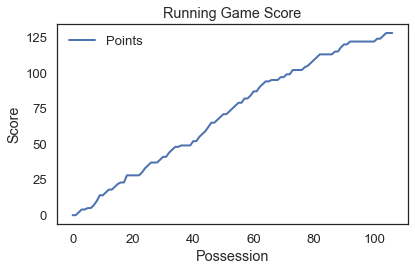

In [56]:
# Test simulate_game
game_score, game_stats = simulate_game(team_A)

plot(game_score, label='Points')

decorate(title='Running Game Score',
         xlabel='Possession', 
         ylabel='Score')

game_score.max()

In [57]:
game_stats

,values
turnovers,15
two_point_field_goal_attempts,48
two_point_field_goal_makes,34
three_point_field_goal_attempts,39
three_point_field_goal_makes,14
free_throw_attempts,28
free_throw_makes,18
shooting_fouls_drawn,15
offensive_rebounds,9


Avg Score  : 109.66
Avg TOs    : 12.22
Avg 2P FGAs: 60.23
Avg 2P FGMs: 31.18
Avg 3P FGAs: 27.47
Avg 3P FGMs: 9.85
Avg FTAs   : 23.64
Avg FTMs   : 17.75
Avg SFs    : 12.81
Avg OffRebs: 9.75


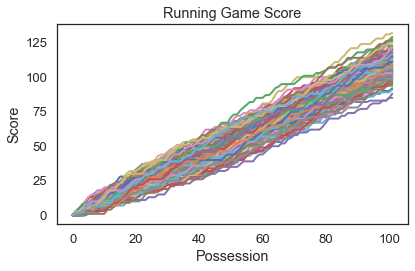

In [58]:
# Let's find the average score for a team (Spurs) ... should be about 113
# Validation of the simulate_game model
spurs = map_team_stats_to_system('SAS')


results = TimeSeries()
turnovers = TimeSeries()
two_point_field_goal_attempts = TimeSeries()
two_point_field_goal_makes = TimeSeries()
three_point_field_goal_attempts = TimeSeries()
three_point_field_goal_makes = TimeSeries()
free_throw_attempts = TimeSeries()
free_throw_makes = TimeSeries()
shooting_fouls_drawn = TimeSeries()
offensive_rebounds = TimeSeries()

for g in range(1, 101):    
    game_score, game_stats = simulate_game(spurs)
    results[g] = game_score.max()
    turnovers[g] = game_stats.turnovers
    two_point_field_goal_attempts[g] = game_stats.two_point_field_goal_attempts
    two_point_field_goal_makes[g] = game_stats.two_point_field_goal_makes
    three_point_field_goal_attempts[g] = game_stats.three_point_field_goal_attempts
    three_point_field_goal_makes[g] = game_stats.three_point_field_goal_makes
    free_throw_attempts[g] = game_stats.free_throw_attempts
    free_throw_makes[g] = game_stats.free_throw_makes
    shooting_fouls_drawn[g] = game_stats.shooting_fouls_drawn
    offensive_rebounds[g] = game_stats.offensive_rebounds
    plot(game_score)

decorate(title='Running Game Score',
         xlabel='Possession', 
         ylabel='Score')
    
    
print("Avg Score  :", results.mean())
print("Avg TOs    :", turnovers.mean())
print("Avg 2P FGAs:", two_point_field_goal_attempts.mean())
print("Avg 2P FGMs:", two_point_field_goal_makes.mean())
print("Avg 3P FGAs:", three_point_field_goal_attempts.mean())
print("Avg 3P FGMs:", three_point_field_goal_makes.mean())
print("Avg FTAs   :", free_throw_attempts.mean())
print("Avg FTMs   :", free_throw_makes.mean())
print("Avg SFs    :", shooting_fouls_drawn.mean())
print("Avg OffRebs:", offensive_rebounds.mean())

For documentation purposes: I ran the above simulation 100 times for the Spurs at 11:28am CT 7/12/20. Here are the results:

- Avg Score  : 113.26

- Avg TOs    : 11.33

- Avg 2P FGAs: 59.18

- Avg 2P FGMs: 31.03

- Avg 3P FGAs: 29.18

- Avg 3P FGMs: 11.2

- Avg FTAs   : 23.74

- Avg FTMs   : 17.6

- Avg SFs    : 12.91

- Avg OffRebs: 9.52

Spurs 2019-20 season per-game averages according to https://stats.nba.com/teams/traditional/
Points     : 113.2
Turnovers  : 12.3
2P FGAs    : 60.8 (89.5 - 28.7)
2P FGMs    : 31.3 (42.0 - 10.7)
3P FGAs    : 28.7
3P FGMs    : 10.7
FTAs       : 22.8
FTMs       : 18.4
SFs        : --
OffRebs    : 8.8

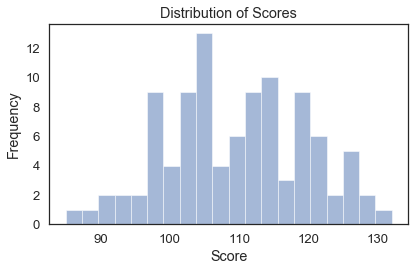

In [60]:
game_totals_ser = pandas.Series(results)

game_totals_ser.plot.hist(bins=20, alpha=0.5, legend=False)

decorate(title='Distribution of Scores',
         xlabel='Score', 
         ylabel='Frequency',
         legend=None)

In [61]:
def is_game_tied(score_one, score_two):
    """
    Determine if game is tied based on two scores (integers)
    """
    
    result = false
    
    if (score_one == score_two):
        result = true
        
    return result

In [62]:
def calculate_pace_of_game(team_one_pace, team_two_pace):
    """
    Calculate pace of a game between two teams
    """
    # Calculate average of the pace given the two teams
    return (team_one_pace + team_two_pace) / 2

In [63]:
pace = calculate_pace_of_game(100.6, 101.3)

100.94999999999999

In [64]:
def simulate_matchup_between_two_teams(team_1, team_2, games):
    """
    Simulate a matchup between two teams.
    High level: The simulate_game function is called for each team, and then the results (final scores) are compared
    Algorithm does identify tie games and runs a simulation for overtime until there is a winner
    games: games per matchup simulation
    """
    
    # Map statistics from input file
    team_one = map_team_stats_to_system(team_1)
    team_two = map_team_stats_to_system(team_2)
    
    # Calculate pace of game based on the two teams
    matchup_pace =  calculate_pace_of_game(team_one.pace, team_two.pace)
    
    # Modify shooting percentages based on offensive and defensive team ratings
    team_one.two_pt_fg_shooting_pct = calculate_fg_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.two_pt_fg_shooting_pct)
    team_one.three_pt_fg_shooting_pct = calculate_3p_fg_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.three_pt_fg_shooting_pct)
    
    team_two.two_pt_fg_shooting_pct = calculate_fg_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.two_pt_fg_shooting_pct)
    team_two.three_pt_fg_shooting_pct = calculate_3p_fg_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.three_pt_fg_shooting_pct)

    # Modify turnover percentages based on offensive and defensive team ratings
    team_one.turnover_pct_per_play = calculate_turnover_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.turnover_pct_per_play)
    team_two.turnover_pct_per_play = calculate_turnover_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.turnover_pct_per_play)

    
    # Initialize matchup state
    matchup = State(team_one_wins=0,
                    team_two_wins=0,
                    overtime_games=0,
                    games=0)
    
    # Create TimeSeries object to track the game result difference
    game_result_diff = TimeSeries()
    
    # Loop through a game X number of times based on input parameter
    for g in range(1, games+1):
        matchup.games += 1
                
        # Always re-initialize pace
        team_one.pace = matchup_pace
        team_two.pace = matchup_pace
        
        gm_team_one, gm_team_one_stats = simulate_game(team_one)
        gm_team_two, gm_team_two_stats = simulate_game(team_two)
        
        if (gm_team_one.max() > gm_team_two.max()):
            matchup.team_one_wins += 1
            game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
        elif (gm_team_two.max() > gm_team_one.max()):
            matchup.team_two_wins += 1
            game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
        else:
            # Tie: Send game to overtime
            matchup.overtime_games += 1
            score_tied = True
            
            # Modify pace for 5 minutes
            ot_pace = (matchup_pace / 48) * 5
            team_one.pace = ot_pace
            team_two.pace = ot_pace
            
            while (score_tied):
                
                gm_team_one, gm_team_one_stats = (simulate_game(team_one))
                gm_team_two, gm_team_two_stats = (simulate_game(team_two))
                
                if (gm_team_one.max() > gm_team_two.max()):
                    matchup.team_one_wins += 1
                    game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
                    score_tied = False
                elif (gm_team_two.max() > gm_team_one.max()):
                    matchup.team_two_wins += 1
                    game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
                    score_tied = False
                        
    return matchup, game_result_diff

In [65]:
# Test map_team_stats_to_system
team_A = map_team_stats_to_system('DAL')

team_A

,values
turnover_pct_per_play,0.112
fga_pct_per_play,0.886
off_reb_per_play,0.093
two_pt_fg_attempts_pct,0.539
two_pt_fg_shooting_pct,0.542
three_pt_fg_shooting_pct,0.369
ft_shooting_pct,0.773
shooting_foul_drawn_pct,0.081
pace,99.780
off_rating,115.800


In [66]:
matchup_results, pt_diffs = simulate_matchup_between_two_teams('MIL', 'LAL', 101)

matchup_results

,values
team_one_wins,56
team_two_wins,45
overtime_games,4
games,101


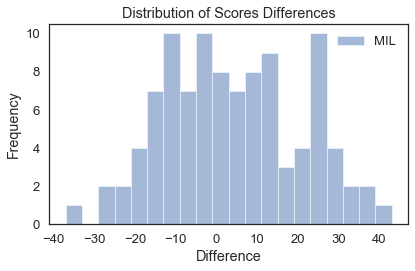

In [67]:
pt_diffs_ser = pandas.Series(pt_diffs)

pt_diffs_ser.plot.hist(bins=20, alpha=0.5, label='MIL')

decorate(title='Distribution of Scores Differences',
         xlabel='Difference', 
         ylabel='Frequency',
         legend='MIL')

In [68]:
pt_diffs.mean()

3.405940594059406

In [69]:
def simulate_playoffs(eastern_conf, western_conf, games_per_series_sim):
    """
    Simulate NBA playoffs
    """
    
    # Set number of game simulations per matchup
    games = games_per_series_sim
    
    # ===== Simulate first round =====
    
    # Eastern conference
    first_rd_east_series_one_results, first_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[0], eastern_conf[7], games)
    first_rd_east_series_one_winner = determine_series_winner(eastern_conf[0], eastern_conf[7], first_rd_east_series_one_results)
    output_playoff_series_result(eastern_conf[0], eastern_conf[7], first_rd_east_series_one_results)
    
    first_rd_east_series_two_results, first_rd_east_series_two_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[3], eastern_conf[4], games)
    first_rd_east_series_two_winner = determine_series_winner(eastern_conf[3], eastern_conf[4], first_rd_east_series_two_results)
    output_playoff_series_result(eastern_conf[3], eastern_conf[4], first_rd_east_series_two_results)
    
    first_rd_east_series_three_results, first_rd_east_series_three_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[1], eastern_conf[6], games)
    first_rd_east_series_three_winner = determine_series_winner(eastern_conf[1], eastern_conf[6], first_rd_east_series_three_results)
    output_playoff_series_result(eastern_conf[1], eastern_conf[6], first_rd_east_series_three_results)
    
    first_rd_east_series_four_results, first_rd_east_series_four_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[2], eastern_conf[5], games)
    first_rd_east_series_four_winner = determine_series_winner(eastern_conf[2], eastern_conf[5], first_rd_east_series_four_results)
    output_playoff_series_result(eastern_conf[2], eastern_conf[5], first_rd_east_series_four_results)
    
    
    # Western conference
    first_rd_west_series_one_results, first_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(western_conf[0], western_conf[7], games)
    first_rd_west_series_one_winner = determine_series_winner(western_conf[0], western_conf[7], first_rd_west_series_one_results)
    output_playoff_series_result(western_conf[0], western_conf[7], first_rd_west_series_one_results)
    
    first_rd_west_series_two_results, first_rd_west_series_two_pt_diffs = simulate_matchup_between_two_teams(western_conf[3], western_conf[4], games)
    first_rd_west_series_two_winner = determine_series_winner(western_conf[3], western_conf[4], first_rd_west_series_two_results)
    output_playoff_series_result(western_conf[3], western_conf[4], first_rd_west_series_two_results)
    
    first_rd_west_series_three_results, first_rd_west_series_three_pt_diffs = simulate_matchup_between_two_teams(western_conf[1], western_conf[6], games)
    first_rd_west_series_three_winner = determine_series_winner(western_conf[1], western_conf[6], first_rd_west_series_three_results)
    output_playoff_series_result(western_conf[1], western_conf[6], first_rd_west_series_three_results)
    
    first_rd_west_series_four_results, first_rd_west_series_four_pt_diffs = simulate_matchup_between_two_teams(western_conf[2], western_conf[5], games)
    first_rd_west_series_four_winner = determine_series_winner(western_conf[2], western_conf[5], first_rd_west_series_four_results)
    output_playoff_series_result(western_conf[2], western_conf[5], first_rd_west_series_four_results)

        
    # ===== Simulate second round =====
    
    # Eastern Conference
    second_rd_east_series_one_results, second_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(first_rd_east_series_one_winner, first_rd_east_series_two_winner, games)
    second_rd_east_series_one_winner = determine_series_winner(first_rd_east_series_one_winner, first_rd_east_series_two_winner, second_rd_east_series_one_results)
    output_playoff_series_result(first_rd_east_series_one_winner, first_rd_east_series_two_winner, second_rd_east_series_one_results)
    
    second_rd_east_series_two_results, second_rd_east_series_two_pt_diffs = simulate_matchup_between_two_teams(first_rd_east_series_three_winner, first_rd_east_series_four_winner, games)
    second_rd_east_series_two_winner = determine_series_winner(first_rd_east_series_three_winner, first_rd_east_series_four_winner, second_rd_east_series_two_results)
    output_playoff_series_result(first_rd_east_series_three_winner, first_rd_east_series_four_winner, second_rd_east_series_two_results)

    # Western Conference
    second_rd_west_series_one_results, second_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(first_rd_west_series_one_winner, first_rd_west_series_two_winner, games)
    second_rd_west_series_one_winner = determine_series_winner(first_rd_west_series_one_winner, first_rd_west_series_two_winner, second_rd_west_series_one_results)
    output_playoff_series_result(first_rd_west_series_one_winner, first_rd_west_series_two_winner, second_rd_west_series_one_results)
    
    second_rd_west_series_two_results, second_rd_west_series_two_pt_diffs = simulate_matchup_between_two_teams(first_rd_west_series_three_winner, first_rd_west_series_four_winner, games)
    second_rd_west_series_two_winner = determine_series_winner(first_rd_west_series_three_winner, first_rd_west_series_four_winner, second_rd_west_series_two_results)
    output_playoff_series_result(first_rd_west_series_three_winner, first_rd_west_series_four_winner, second_rd_west_series_two_results)

        
    # ===== Simulate conference finals =====
    
    # Eastern Conference
    third_rd_east_series_one_results, third_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(second_rd_east_series_one_winner, second_rd_east_series_two_winner, games)
    third_rd_east_series_one_winner = determine_series_winner(second_rd_east_series_one_winner, second_rd_east_series_two_winner, third_rd_east_series_one_results)
    output_playoff_series_result(second_rd_east_series_one_winner, second_rd_east_series_two_winner, third_rd_east_series_one_results)

    # Western Conference
    third_rd_west_series_one_results, third_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(second_rd_west_series_one_winner, second_rd_west_series_two_winner, games)
    third_rd_west_series_one_winner = determine_series_winner(second_rd_west_series_one_winner, second_rd_west_series_two_winner, third_rd_west_series_one_results)
    output_playoff_series_result(second_rd_west_series_one_winner, second_rd_west_series_two_winner, third_rd_west_series_one_results)

    
    # ===== Simulate NBA finals =====
    nba_finals_results, nba_finals_pt_diffs = simulate_matchup_between_two_teams(third_rd_east_series_one_winner, third_rd_west_series_one_winner, games)
    nba_finals_winner = determine_series_winner(third_rd_east_series_one_winner, third_rd_west_series_one_winner, nba_finals_results)
    output_playoff_series_result(third_rd_east_series_one_winner, third_rd_west_series_one_winner, nba_finals_results)

    
    return nba_finals_winner


In [70]:
def output_playoff_series_result(team_one, team_two, results):
    """
    Display to screen the playoff series result
    """
    
    print("===== Series Result =====")
    
    print(team_one, "wins:", results.team_one_wins)
    print(team_two, "wins:", results.team_two_wins)
    
    if (results.team_one_wins > results.team_two_wins):
        print ("Series Winner:", team_one)
    else:
        print ("Series Winner:", team_two)

In [71]:
# Test output_playoff_series_result
output_playoff_series_result('DAL', 'NYK', matchup_results)

===== Series Result =====
DAL wins: 56
NYK wins: 45
Series Winner: DAL


In [72]:
def determine_series_winner(team_one, team_two, results):
    """
    Determin the series winner based on the results object from a matchup
    """
    
    winner = team_two
    
    if (results.team_one_wins > results.team_two_wins):
        winner = team_one
        
    return winner

In [77]:
# Standings as of July 11, 2020
east = ['MIL', 'TOR', 'BOS', 'MIA', 'IND', 'PHI', 'BKN', 'ORL']
west = ['LAL', 'LAC', 'DEN', 'UTA', 'OKC', 'HOU', 'DAL', 'MEM']

# Test simulate_playoffs
start_time = time.time()

simulate_playoffs(east, west, 101)

print("--- %s seconds ---" % (time.time() - start_time))

===== Series Result =====
MIL wins: 76
ORL wins: 25
Series Winner: MIL
===== Series Result =====
MIA wins: 47
IND wins: 54
Series Winner: IND
===== Series Result =====
TOR wins: 66
BKN wins: 35
Series Winner: TOR
===== Series Result =====
BOS wins: 62
PHI wins: 39
Series Winner: BOS
===== Series Result =====
LAL wins: 61
MEM wins: 40
Series Winner: LAL
===== Series Result =====
UTA wins: 56
OKC wins: 45
Series Winner: UTA
===== Series Result =====
LAC wins: 56
DAL wins: 45
Series Winner: LAC
===== Series Result =====
DEN wins: 55
HOU wins: 46
Series Winner: DEN
===== Series Result =====
MIL wins: 60
IND wins: 41
Series Winner: MIL
===== Series Result =====
TOR wins: 61
BOS wins: 40
Series Winner: TOR
===== Series Result =====
LAL wins: 57
UTA wins: 44
Series Winner: LAL
===== Series Result =====
LAC wins: 62
DEN wins: 39
Series Winner: LAC
===== Series Result =====
MIL wins: 57
TOR wins: 44
Series Winner: MIL
===== Series Result =====
LAL wins: 54
LAC wins: 47
Series Winner: LAL
===== 